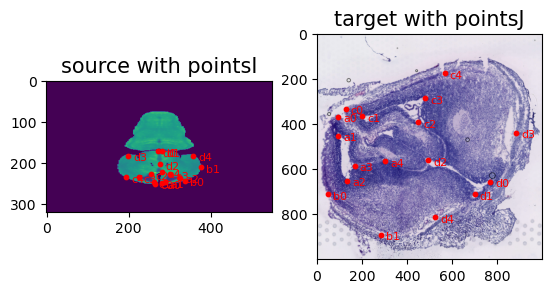

In [1]:
#%%
#Import dependencies
from scipy.ndimage import rotate
import numpy as np
#%matplotlib notebook
import nibabel as nib
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os

from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
import copy
import skimage
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
## OPTION B: skip cell if installed STalign with pip or pipenv
import sys
sys.path.append("../../STalign") 

## import STalign from upper directory
import STalign
image_file = '../visium_data/tissue_hires_image_test.png'
V = plt.imread(image_file)

# plot
# fig,ax = plt.subplots()
# ax.imshow(V)
Vnorm = STalign.normalize(V)
J = Vnorm.transpose(2,0,1)
J=J[0:200,1000:2000,300:1300]
# print("The new shape of J is {}".format(J.shape))

# YJ = np.array(range(J.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
# XJ = np.array(range(J.shape[2]))*1.
# nii_img  = nib.load('../E13-5_MRI_34um/E13-5_LSFM_20um_masked_1.nii.gz')
# nii_data = nii_img.get_fdata()
# I=nii_data[:,170,:]
YJ = np.array(range(J.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = np.array(range(J.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
# # fig,ax = plt.subplots(1,2)
# theta_deg = 90
# theta_deg2 = -50
# extentA = STalign.extent_from_x((YJ,XJ))
X_=np.arange(0, 1000, 1)
Y_=np.arange(0, 1000, 1)
# W=J[:,:,:]
# W[W > 0.8] = 0
xJ = [Y_,X_]
# J = W[None]/np.mean(np.abs(W))
vol,hdr = nrrd.read('../E13-5_MRI_34um/E13-5_LSFM_20um_masked_1.nrrd',index_order='F')
A = vol.transpose(1,2,0) 
slice = 170
#theta_deg = 90

hdr['space directions']=-1*hdr['space directions']
hdr['space directions'][0][0]=0.02
hdr['space directions'][1][1]=0.02
hdr['space directions'][2][2]=0.02
hdr['space directions']=1*hdr['space directions']
dxA = np.diag(hdr['space directions'])
nxA = A.shape
xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
XA = np.meshgrid(*xA,indexing='ij')

# fig,ax = plt.subplots(1,2)
# extentA = STalign.extent_from_x(xA[1:])
# ax[0].imshow(rotate(A[slice], angle=theta_deg),extent=extentA,interpolation='none')
# ax[0].set_title('Atlas Slice')

# ax[1].imshow(W,extent=extentA,interpolation='none')
# ax[1].set_title('Target Image')
# #fig.savefig('_image.png', dpi = 1200)
# #fig.show()
# fig.canvas.draw()
xI = xA
I = A[None] / np.mean(np.abs(A),keepdims=True)
I = np.concatenate((I,(I-np.mean(I))**2))
# ax[0].imshow(rotate((J).transpose(1,2,0), angle=theta_deg2))
# ax[0].set_title('target', fontsize=15)
# ax[1].imshow(rotate(I, angle=theta_deg),extent=extentA)
# ax[1].set_title('Target Image')
# fig.canvas.draw()   
YI = np.array(range(I.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XI = np.array(range(I.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 
np.savez('../test/model',x=XI,y=YI,I=I[0:1,170])
np.savez('../test/visum', x=XJ,y=YJ,I=J)
# read from file
pointsIlist = np.load('../test/model_points.npy', allow_pickle=True).tolist()
# print(pointsIlist)
pointsJlist = np.load('../test/visum_points.npy', allow_pickle=True).tolist()
# print(pointsJlist)
pointsI = []
pointsJ = []

YI = np.array(range(I.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XI = np.array(range(I.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        pointsI.append([pointsIlist[i][j][1], pointsIlist[i][j][0]])
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        pointsJ.append([pointsJlist[i][j][1], pointsJlist[i][j][0]])
    
pointsI = np.array(pointsI)
pointsJ = np.array(pointsJ)
fig,ax = plt.subplots(1,2)
extentJ = STalign.extent_from_x((YJ,XJ))
# extentA = STalign.extent_from_x(xA[1:])
extentI = STalign.extent_from_x((YI,XI))
theta_deg = -(90+30)
ax[0].imshow((I[0:1,170].transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)

trans_offset_0 = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
trans_offset_1 = mtransforms.offset_copy(ax[1].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')

ax[0].scatter(pointsI[:,1],pointsI[:,0], c='red', s=10)
ax[1].scatter(pointsJ[:,1],pointsJ[:,0], c='red', s=10)
    
for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        ax[0].text(pointsIlist[i][j][0], pointsIlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_0, fontsize= 8)
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        ax[1].text(pointsJlist[i][j][0], pointsJlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_1, fontsize= 8)
        
ax[0].set_title('source with pointsI', fontsize=15)
ax[1].set_title('target with pointsJ', fontsize=15)


# compute initial affine transformation from points
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')
Li,Ti = STalign.L_T_from_points(pointsI,pointsJ)

sigmaA = 2 #standard deviation of artifact intensities
sigmaB = 2 #standard deviation of background intensities
sigmaM = 2 #standard deviation of matching tissue intenities
# muA = torch.tensor([3,3,3],device='cpu') #average of artifact intensities
# muB = torch.tensor([0,0,0],device='cpu') #average of background intensities
# initialize variables
scale_x = 0.9 #default = 0.9
scale_y = 0.9 #default = 0.9A
scale_z = 0.9 #default = 0.9
theta0 = (np.pi/180)*theta_deg


extentJ = STalign.extent_from_x((YJ,XJ))
extentI = STalign.extent_from_x((YI,XI))


# fig,ax = plt.subplots(1,2)
# ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
# ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)

# trans_offset_0 = mtransforms.offset_copy(ax[0].transData, fig=fig,
#                                        x=0.05, y=-0.05, units='inches')
# trans_offset_1 = mtransforms.offset_copy(ax[1].transData, fig=fig,
#                                        x=0.05, y=-0.05, units='inches')

# ax[0].scatter(pointsI[:,1],pointsI[:,0], c='red', s=10)
# ax[1].scatter(pointsJ[:,1],pointsJ[:,0], c='red', s=10)
    
# for i in pointsIlist.keys():
#     for j in range(len(pointsIlist[i])):
#         ax[0].text(pointsIlist[i][j][0], pointsIlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_0, fontsize= 8)
# for i in pointsJlist.keys():
#     for j in range(len(pointsJlist[i])):
#         ax[1].text(pointsJlist[i][j][0], pointsJlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_1, fontsize= 8)
        
# ax[0].set_title('source with pointsI', fontsize=15)
# ax[1].set_title('target with pointsJ', fontsize=15)

# # invert only rasterized image
# ax[0].invert_yaxis()
# get an initial guess
if "Ti" in locals() :
    T = np.array([-xI[0][slice],np.mean(xJ[0])-(Ti[0]*scale_y),np.mean(xJ[1])-(Ti[1]*scale_x)])
else:
    T = np.array([-xI[0][slice],np.mean(xJ[0]),np.mean(xJ[1])])

scale_atlas = np.array([[scale_z,0,0],
                        [0,scale_x,0],
                        [0,0,scale_y]])
L = np.array([[1.0,0.0,0.0],
             [0.0,np.cos(theta0),-np.sin(theta0)],
              [0.0,np.sin(theta0),np.cos(theta0)]])
L = np.matmul(L,scale_atlas)#np.identity(3)


# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
xI = xA


In [2]:
dtype=torch.float64
expand=1.25
a=500.0
nt=3
minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand
xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)]
XV = torch.stack(torch.meshgrid(xv),-1)
v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2],XV.shape[3]),device=device,dtype=dtype,requires_grad=True)


/home/albert/anaconda3/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


/home/albert/Documentos/GitHub/STalign/docs/notebooks/../../STalign/STalign.py:1616: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


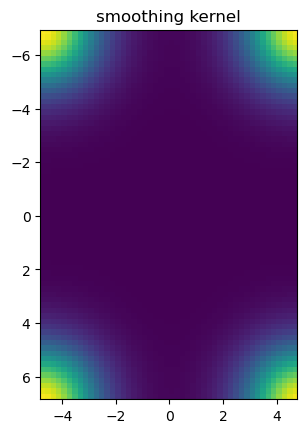

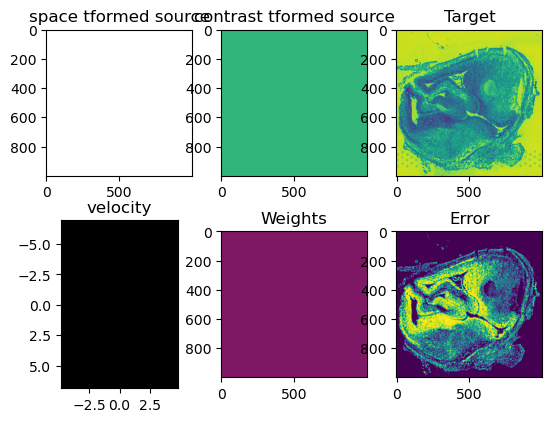

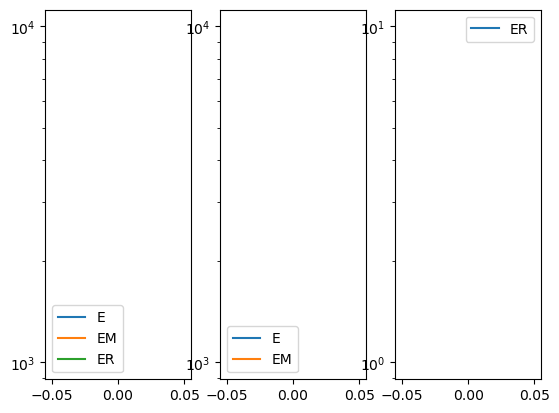

In [3]:
#returns mat = affine transform, v = velocity, xv = pixel locations of velocity points


# %%
transform = STalign.LDDMM_3D_to_slice(
    xI,I,xJ,J,
    T=T,L=L,
    nt=4,niter=4,
    device='cpu',
    a=0.4,
    sigmaA = sigmaA, #standard deviation of artifact intensities
    sigmaB = sigmaB, #standard deviation of background intensities
    sigmaM = sigmaM, #standard deviation of matching tissue intenities
    # muA = muA, #average of artifact intensities
    # muB = muB #average of background intensities
)